# Project - Review Score Prediction of Olist E-commerce

**Author:** Robson de Castro Serafim  
**Submission date:** 25/08/2025


**Context**

This dataset was provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on their website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, the customer gets a satisfaction survey by email where he can give a **note for the purchase experience.**
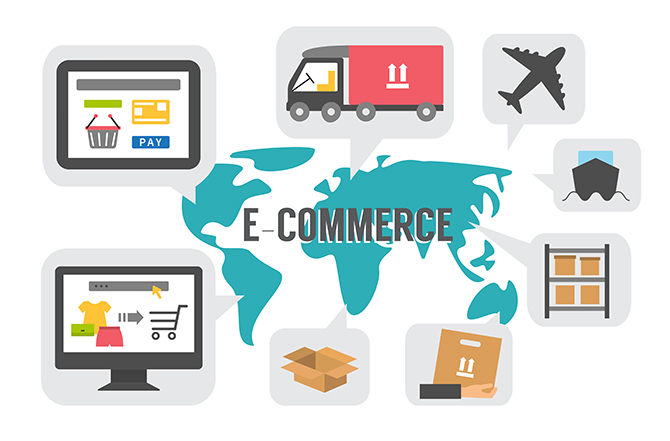


**1. Business Area Requirements:**

1.1 Customer Profiling: Understanding the customer profile.

1.2 Assessment of Ratings: Understanding our current performance in evaluations.

1.3 Area Objective: To receive predominantly 5 and 4 ratings.

**2. Purpose of the data science project:**

2.1 Developing a model to predict customer ratings.

2.2 Determine the most influential features that impact customer ratings, using interpretable/explainable machine learning models.

2.3 Implementing proactive measures to address potential low ratings

# 1. Import Libraries

In [ ]:
## Connecting to Google drive

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing project dependencies**:

To ensure all required packages are available, we will install the dependencies listed in the `requirements.txt` file


In [ ]:
requirements_path = '/content/drive/MyDrive/Colab Notebooks/Olist_project/main_project/requirements.txt'

!pip install -r "$requirements_path" -qqq

In [ ]:
import math
import pandas as pd
import numpy as np

import os, sys
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import json
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.base import clone

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

import socket, time

import optuna


# No warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 2. Merge Big Table
**The present dataset has different data sources, each table specifying a topic of e-commerce sales. The tables are separated into:**
1. Costumers
2. Geolocation
3. Orders
4. Order items
5. Payments
6. Order reviews
7. Products
8. Sellers
9. Product category name

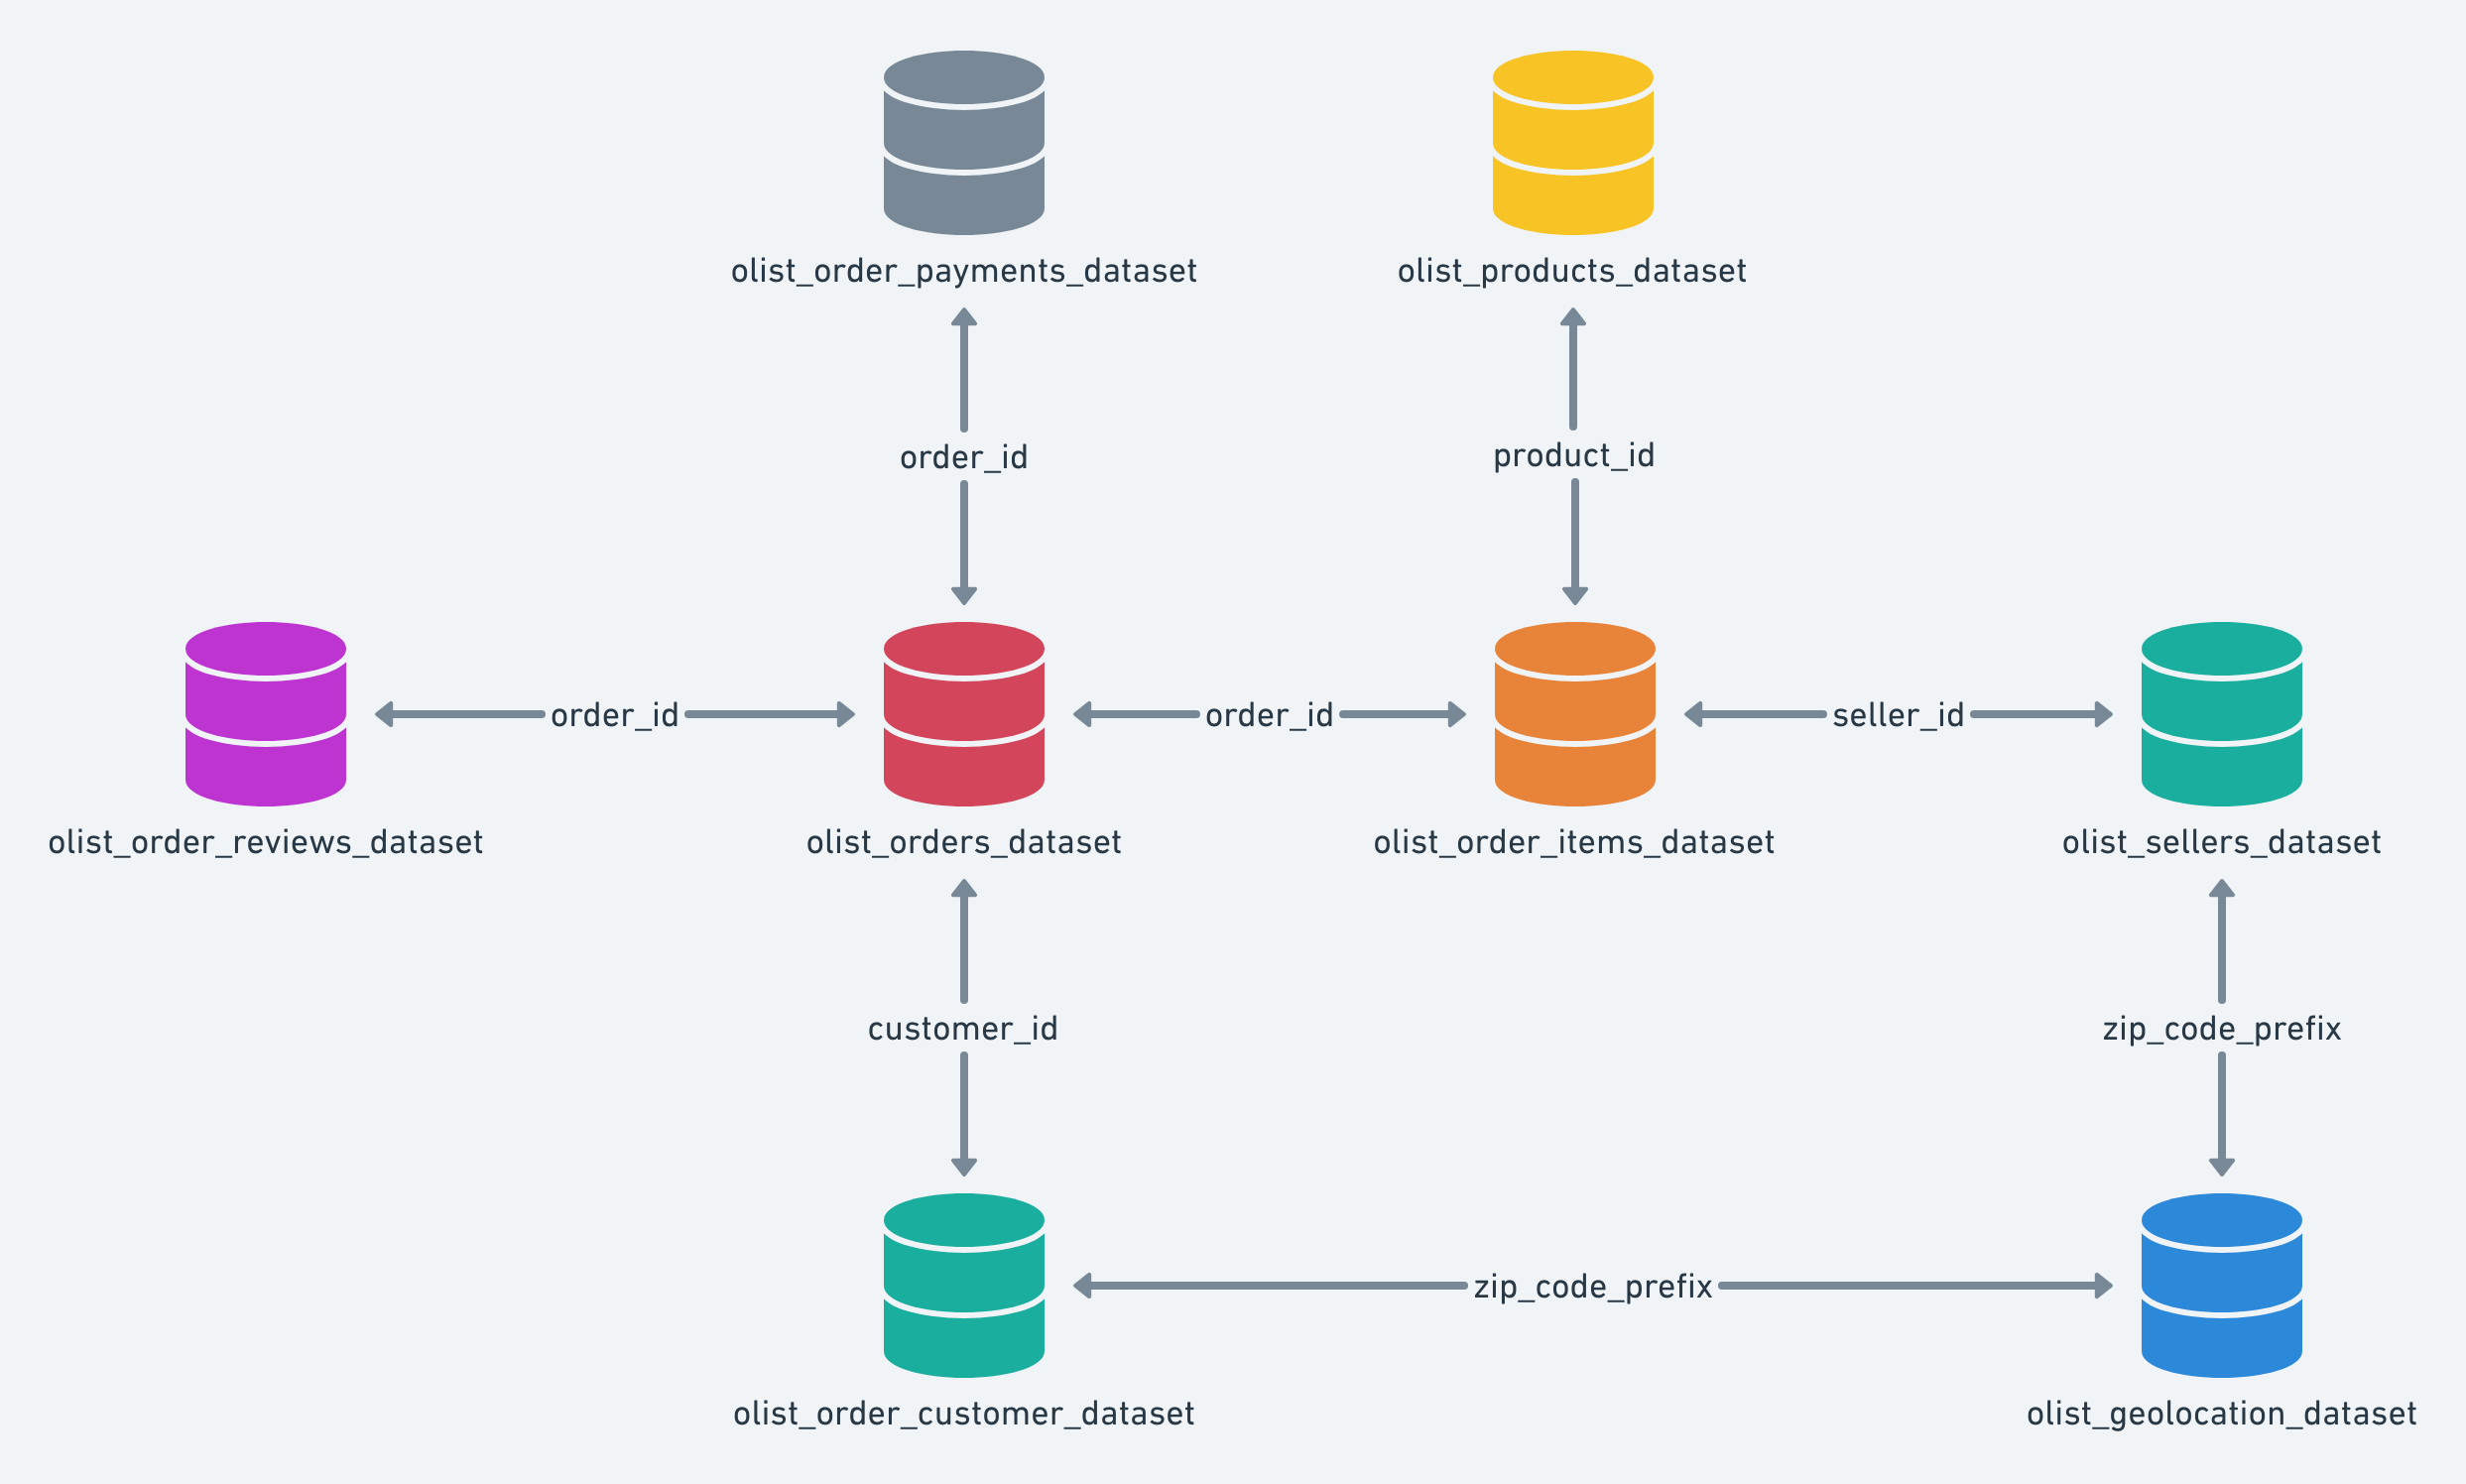

**Using SQL language I created a Big table with the union between all the tables and performed a new exploratory analysis with confrontations between the most diverse features of the dataset,** so that we can perform a full exploratory analysis of the dataset, with the following code below:

```
SELECT *
FROM customer AS c
LEFT JOIN orders AS o ON o.customer_id = c.customer_id
LEFT JOIN order_payments AS op ON op.order_id = o.order_id
LEFT JOIN order_reviews AS or2 ON or2.order_id = o.order_id
LEFT JOIN order_items AS oi ON oi.order_id = o.order_id
LEFT JOIN products AS p ON p.product_id = oi.product_id
LEFT JOIN sellers AS s ON s.seller_id = oi.seller_id;
```
The JOINS mentioned above were based on the Data Schema provided by Olist to understand the relationships and foreign keys between the tables.

Then we export the table as a CSV file called **'Olist_bigdata.csv'.**

# 4. Functions

In [ ]:
def load_data(filename, sep=',', encoding='utf-8', show_head=False):
    """
    Loads a CSV file from the configured DATA_PATH and displays the shape.

    Parameters:
    - filename (str): name of the .csv file (ex: 'Olist_bigdata.csv')
    - sep (str): separator (default: ',')
    - encoding (str): encoding (default: 'utf-8')
    - show_head (bool): if True, shows the first 5 rows

    Returns:
    - df (pandas.DataFrame)
    """
    file_path = Path(DATA_PATH) / filename
    try:
        df = pd.read_csv(file_path, sep=sep, encoding=encoding)
        print(f"- Data loaded successfully: {df.shape[0]} rows × {df.shape[1]} columns.")
        if show_head:
            display(df.head())
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error loading file: {e}")

In [ ]:
def convert_to_datetime(df, columns, date_format='%Y-%m-%d %H:%M:%S'):
    '''
    Converts a list of DataFrame columns to datetime format.

    Parameters:
    - df (pd.DataFrame): the input DataFrame
    - columns (list): list of column names to convert
    - date_format (str): expected format of the date strings

    Returns:
    - pd.DataFrame: the updated DataFrame with converted columns
    '''
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=date_format, errors='coerce')
    return df

In [ ]:
def split_train_test(df, target_column, test_size=0.3, random_state=10):
    '''
    Splits a DataFrame into training and testing sets for features and target.

    Parameters:
    - df (pd.DataFrame): the full DataFrame
    - target_column (str): the name of the target column
    - test_size (float): proportion of the dataset to include in the test split (default is 0.3)
    - random_state (int): random seed for reproducibility (default is 10)

    Returns:
    - x_train, x_test, y_train, y_test: split datasets
    '''
    x = df.drop(target_column, axis=1)
    y = df[target_column]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state
    )

    print(f'Train Data: {x_train.shape}, {y_train.shape}')
    print(f'Test Data:  {x_test.shape}, {y_test.shape}')

    return x_train, x_test, y_train, y_test

In [ ]:
def log_classification_model(model_name, run_name, pipeline_model, x_train, y_train, x_test, y_test):
    with mlflow.start_run(run_name=run_name) as run:
        run_id = run.info.run_id

        # Predict
        y_pred_train = pipeline_model.predict(x_train)
        y_pred_test = pipeline_model.predict(x_test)

        # Probabilities (for ROC AUC)
        y_proba_test = pipeline_model.predict_proba(x_test)[:, 1] if hasattr(pipeline_model, 'predict_proba') else None

        # Metrics
        acc = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test)
        prec = precision_score(y_test, y_pred_test)
        recall = recall_score(y_test, y_pred_test)
        roc_auc = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else None

        # Params
        mlflow.log_param('model_type', model_name)

        # Metrics
        mlflow.log_metric('accuracy', acc)
        mlflow.log_metric('f1_score', f1)
        mlflow.log_metric('precision', prec)
        mlflow.log_metric('recall', recall)
        if roc_auc is not None:
            mlflow.log_metric('roc_auc', roc_auc)

        # Prepare input example and signature (for model serving)
        input_example = x_test.head()
        output_example = pipeline_model.predict(input_example)
        signature = infer_signature(input_example, output_example)

        # Log the full pipeline
        mlflow.sklearn.log_model(
            pipeline_model,
            name='model',
            input_example=input_example,
            signature=signature
        )

        # print(f'[MLflow] {model_name} → accuracy: {acc:.3f} | f1: {f1:.3f} | ROC AUC: {roc_auc:.3f}')
        print(f'[MLflow] Run ID: {run_id}')
        return run_id


In [ ]:
def wait_port(host, port, timeout=15):
    start = time.time()
    while time.time() - start < timeout:
        with socket.socket() as s:
            s.settimeout(1)
            try:
                s.connect((host, port))
                return True
            except Exception:
                time.sleep(0.3)
    return False

# Set your data path

In [ ]:
# === Data path configuration ===
# Adjust this depending on where you are running the notebook:

# Your Olist_data.csv path:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Olist_project/main_project/data"

# On Docker (with volume mounted at /app):
#DATA_PATH = "/app"

# 3. Read Data

In [ ]:
df = load_data('Olist_data.csv', sep=',')
df.head()

- Data loaded successfully: 108510 rows × 38 columns.


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,credit_card,2.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,credit_card,8.0,335.48,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303.0,itajai,SC
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1.0,credit_card,7.0,157.73,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,8577.0,itaquaquecetuba,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1.0,credit_card,1.0,173.30,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,8577.0,itaquaquecetuba,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1.0,credit_card,8.0,252.25,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,14940.0,ibitinga,SP


## 3.1 Data Description

In [ ]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

df.info()

Number of rows: 108510
Number of columns: 38
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108510 entries, 0 to 108509
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    108510 non-null  object 
 1   customer_unique_id             108510 non-null  object 
 2   customer_zip_code_prefix       108510 non-null  int64  
 3   customer_city                  108510 non-null  object 
 4   customer_state                 108510 non-null  object 
 5   order_id                       108510 non-null  object 
 6   order_status                   108510 non-null  object 
 7   order_purchase_timestamp       108510 non-null  object 
 8   order_approved_at              108334 non-null  object 
 9   order_delivered_carrier_date   106591 non-null  object 
 10  order_delivered_customer_date  105314 non-null  object 
 11  order_estimated_delivery_date  108510 non-null

In [ ]:
#Analysis of statistical distributions

describe_data = df[['payment_value', 'review_score', 'price', 'freight_value', 'product_photos_qty']]
describe_data.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_value,108509.0,157.450174,219.569973,0.00,57.70,102.14,176.15,13664.08
review_score,108510.0,4.040144,1.382331,1.00,4.00,5.00,5.00,5.00
price,107677.0,124.348378,189.402854,0.85,40.00,78.00,139.00,6735.00
freight_value,107677.0,20.151918,15.926436,0.00,13.14,16.35,21.25,409.68
product_photos_qty,106113.0,2.235409,1.739785,1.00,1.00,2.00,3.00,20.00


# 4. Data Cleaning and Preprocessing

## 4.1 Data Transformation

In [ ]:
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'review_creation_date',
    'review_answer_timestamp',
    'shipping_limit_date'
]

df = convert_to_datetime(df, date_columns)

# 5.Exploratory Data Analysis

## 5.1 **Analyzing the Top 10 Customers by payment value**: Which customer has the highest accumulated purchase value?

In [ ]:
df_top_customers = df.groupby('customer_unique_id').payment_value.sum().reset_index().sort_values(by='payment_value', ascending = False).head(10)
df_top_customers

,customer_unique_id,payment_value
10376,1b76903617af13189607a36b0469f6f3,15978.65
3826,0a0a92112bd4c708ca5fde585afaa872,13664.08
81722,d97b3cfb22b0d6b25ac9ed4e9c2d481b,10437.58
26456,46450c74a0d8c5ca9395da1daac6c120,9553.02
75528,c8ed31310fc440a3f8031b177f9842c3,9258.24
60913,a229eba70ec1c2abef51f04987deb7a5,8891.00
19539,33de26d1fafbfd4945eb586f7136efe6,8697.99
2418,066ee6b9c6fc284260ff9a1274a82ca7,8530.14
81962,da122df9eeddfedc1dc1f5349a1a690c,7571.63
44447,763c8b1c9c68a0229c42c9fc6f662b93,7274.88


In [ ]:
#Plotly - 10 top customers by payment value
plotly_1 = go.Bar(x = df_top_customers['customer_unique_id'],
                  y = df_top_customers['payment_value'],
                  name = 'Top 10 Customers by payment value',
                  marker = {'color': '#1f77b4'})

layout = go.Layout(title='Top 10 Customers by payment value',
                   xaxis={'title': 'Customer unique ID'},
                   yaxis={'title': 'Payment value'},
                   width=1050,
                   height=700)


df_plotly_1 = [plotly_1]
fig = go.Figure (data = df_plotly_1, layout = layout)
fig.show()

## 5.2 **Customer Region with highest sales**: In which Brazilian region has the highest accumulated payment value in the dataset?

In [ ]:
#Sales by state

sales_per_state = df.groupby('customer_state').payment_value.sum().reset_index().sort_values(by='payment_value', ascending = False)
sales_per_state.head()

,customer_state,payment_value
25,SP,6434668.51
18,RJ,2283135.35
10,MG,1991391.94
22,RS,949413.59
17,PR,862487.01


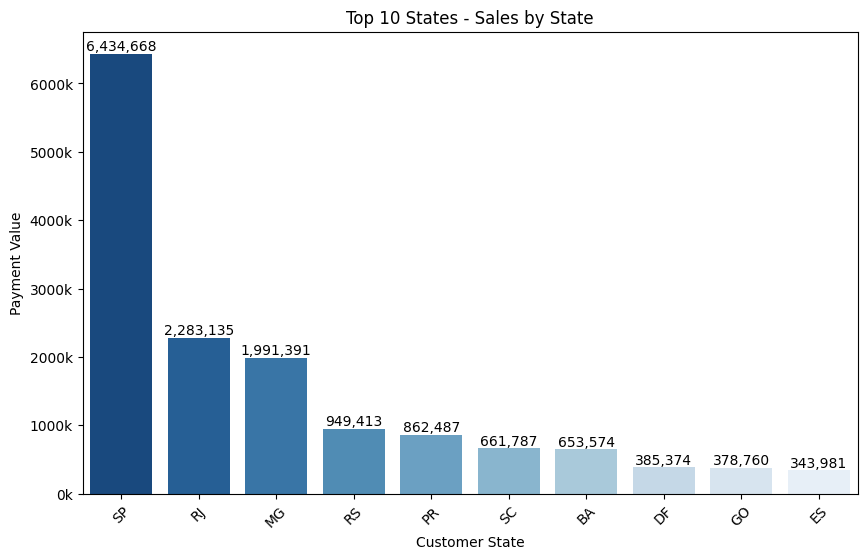

In [ ]:
top_10_states = sales_per_state.head(10)

# Definindo a paleta de cores em tons de azul
colors = sns.color_palette('Blues_r', n_colors=10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_10_states, x='customer_state', y='payment_value', palette=colors)
plt.xlabel('Customer State')
plt.ylabel('Payment Value')
plt.title('Top 10 States - Sales by State')
plt.xticks(rotation=45)

# Formatando os rótulos no eixo Y
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

# Adicionando rótulos de dados acima das barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()


In [ ]:
import plotly.io as pio
import kaleido
from IPython.display import Image, display


#Plot map
br_states = '/content/drive/MyDrive/Colab Notebooks/Olist_project/main_project/data/br_states.json'
geo_json_data = json.load(open(br_states))

fig = px.choropleth(sales_per_state,
                    geojson = geo_json_data,
                    locations = 'customer_state',
                    featureidkey = 'id',
                    projection = 'mercator',
                    color = 'payment_value',
                    labels = {'payment_value': 'Sales'})

fig.update_geos(fitbounds='geojson', visible = True)
fig.update_layout (margin={'r': 0, 't':0, 'l': 0, 'b':0})
fig.show()


# GitHub display
png_bytes = fig.to_image(format="png", scale=1)
display(Image(data=png_bytes))

Output hidden; open in https://colab.research.google.com to view.

## 5.3 **Order purchase month**: The business area is also interested in understanding in which month we have the highest sales and if there is a month that we are below average?

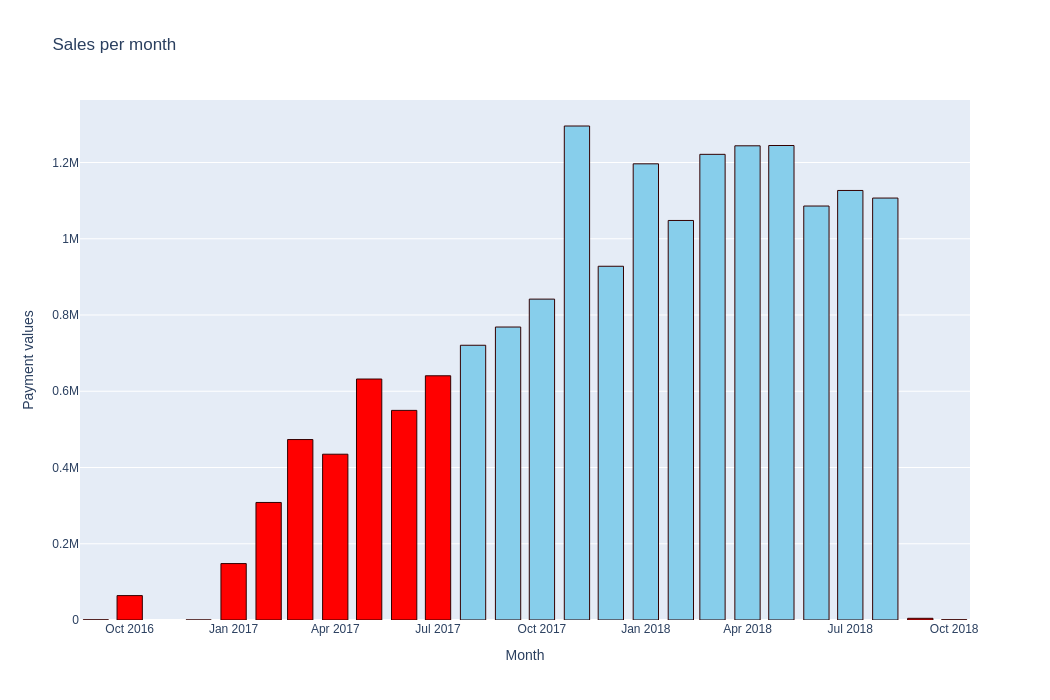

In [ ]:
#Creating a new columns with the Month vision

df['order_purchase_month'] = df.order_purchase_timestamp.dt.to_period('M').astype(str)

# How much sales per month?
sales_per_month = df.groupby(by = 'order_purchase_month').payment_value.sum()

# Color palette by mean values of sales
mean = sales_per_month.values.mean()
color = []

for i in sales_per_month.values:
    if i < mean:
        color.append('red')
    else:
        color.append('skyblue')

#Plotly: If the sale value is lower than the average = red

df_sales_month = go.Bar (x = sales_per_month.index,
                         y = sales_per_month.values,
                         marker = {'color': color,
                                   'line': {'color': '#300', 'width':1}})

layout = go.Layout (title = 'Sales per month',
                    xaxis = {'title':'Month'},
                    yaxis = {'title':'Payment values'},
                    width=1050,
                   height=700)

fig = go.Figure (data = df_sales_month, layout = layout)
fig.show()

# GitHub display
png_bytes = fig.to_image(format="png", scale=1)
display(Image(data=png_bytes))

## 5.4 **Amount of Sales by product category**: On which product category do we have the highest cumulative payment amounts?

In [ ]:
category_values = df.groupby(by = 'product_category_name').payment_value.sum().sort_values(ascending = False).head(10)
category_values

,payment_value
product_category_name,
beleza_saude,1499983.39
cama_mesa_banho,1480753.49
relogios_presentes,1352516.31
esporte_lazer,1210833.55
informatica_acessorios,1157699.18
moveis_decoracao,1032484.17
utilidades_domesticas,826768.36
cool_stuff,738400.90
automotivo,720204.05


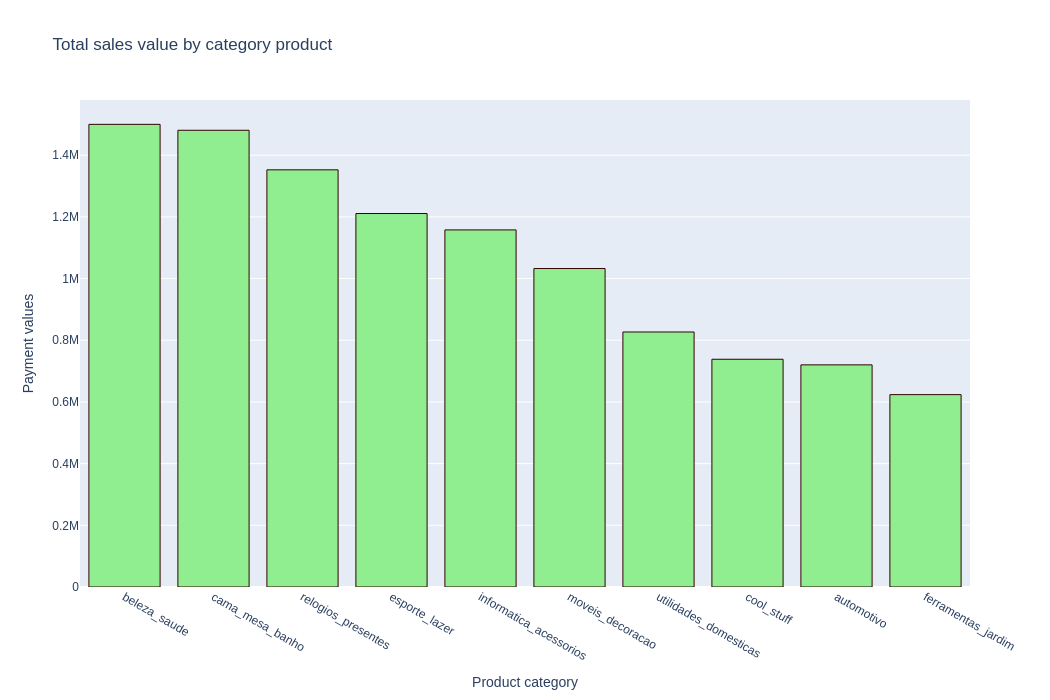

In [ ]:
df_category_values = go.Bar (x = category_values.index,
                            y = category_values.values,
                            marker = {'color': 'lightgreen',
                                   'line': {'color': '#300', 'width':1}})

layout = go.Layout (title = 'Total sales value by category product',
                    xaxis = {'title':'Product category'},
                    yaxis = {'title':'Payment values'},
                    width=1050,
                   height=700)

fig = go.Figure (data = df_category_values, layout = layout)
fig.show()

# GitHub display
png_bytes = fig.to_image(format="png", scale=1)
display(Image(data=png_bytes))

**Payment type**: What is the most used payment method on our platform?

In [ ]:
df['payment_type'].value_counts()

,count
payment_type,
credit_card,80241
boleto,20597
voucher,6069
debit_card,1599
not_defined,3


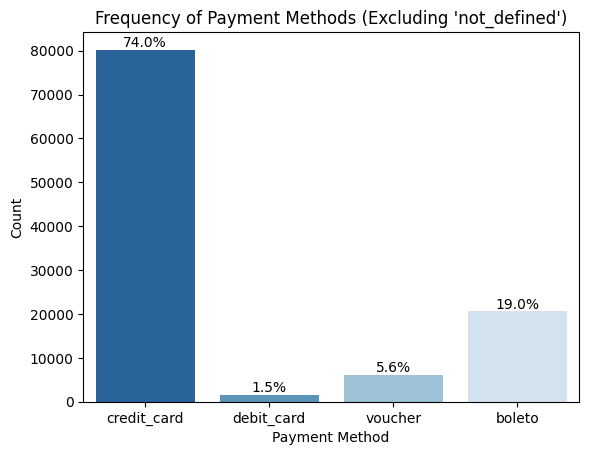

In [ ]:
# Filtering the data and excluding the 'not_defined' values
df_filtered = df[df['payment_type'] != 'not_defined']

# Creating the count plot
ax = sns.countplot(data=df_filtered, x='payment_type', palette='Blues_r')

# Adding count labels on top of each bar (percentage relative to the total)
total = len(df_filtered)
for p in ax.patches:
    percentage = f'{p.get_height() / total * 100:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Setting axis labels
plt.xlabel('Payment Method')
plt.ylabel('Count')

# Setting the chart title
plt.title("Frequency of Payment Methods (Excluding 'not_defined')")

# Displaying the plot
plt.show()

## 5.5 **Review Score**: Which review score do we receive the most about our sales?

In [ ]:
#Top score on reviews of Olist orders
review_counts = df.groupby('review_score').review_id.count().reset_index().sort_values(by='review_id', ascending = False).set_index('review_score')
review_counts

,review_id
review_score,
5,61554
4,20595
1,13546
3,9070
2,3745


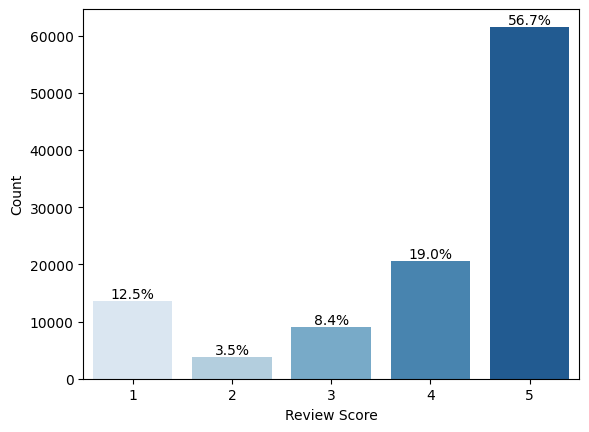

In [ ]:
# Defining a blue color palette
colors = sns.color_palette('Blues', len(review_counts))

# Creating the bar plot
ax = sns.barplot(x=review_counts.index, y='review_id', data=review_counts, palette=colors)

# Adding count labels on top of each bar (percentage relative to the total)
for p in ax.patches:
    percentage = f'{p.get_height() / total * 100:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Setting axis labels
plt.xlabel('Review Score')
plt.ylabel('Count')

# Displaying the plot
plt.show()


## 5.6 Correlation between features

In [ ]:
# Calculate differences in days
df['estimated_delivery_time'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

df['real_delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

In [ ]:
# Boolean: if real_delivery <= estimated delivery = 1 else 0
#So, '1' its good because it was delivered on time.

df.loc[df['real_delivery_time'] <= df['estimated_delivery_time'], 'delivery_on_time'] = 1
df.loc[df['real_delivery_time'] > df['estimated_delivery_time'], 'delivery_on_time'] = 0

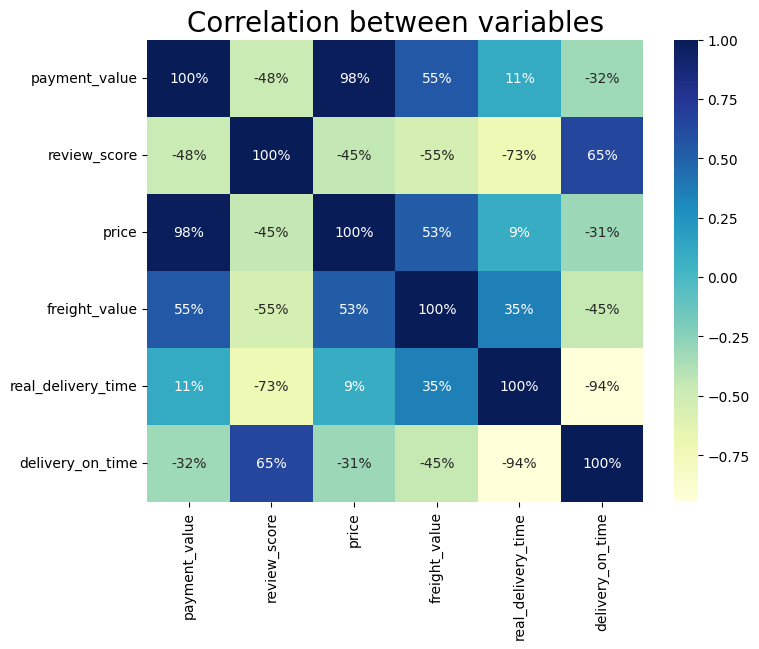

In [ ]:
corr = df[['payment_value', 'review_score', 'price', 'freight_value', 'real_delivery_time','delivery_on_time']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr.corr(), annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Correlation between variables', fontsize = 20);

**Delivery time are the features with most strongly correlated** with the review score (our target).

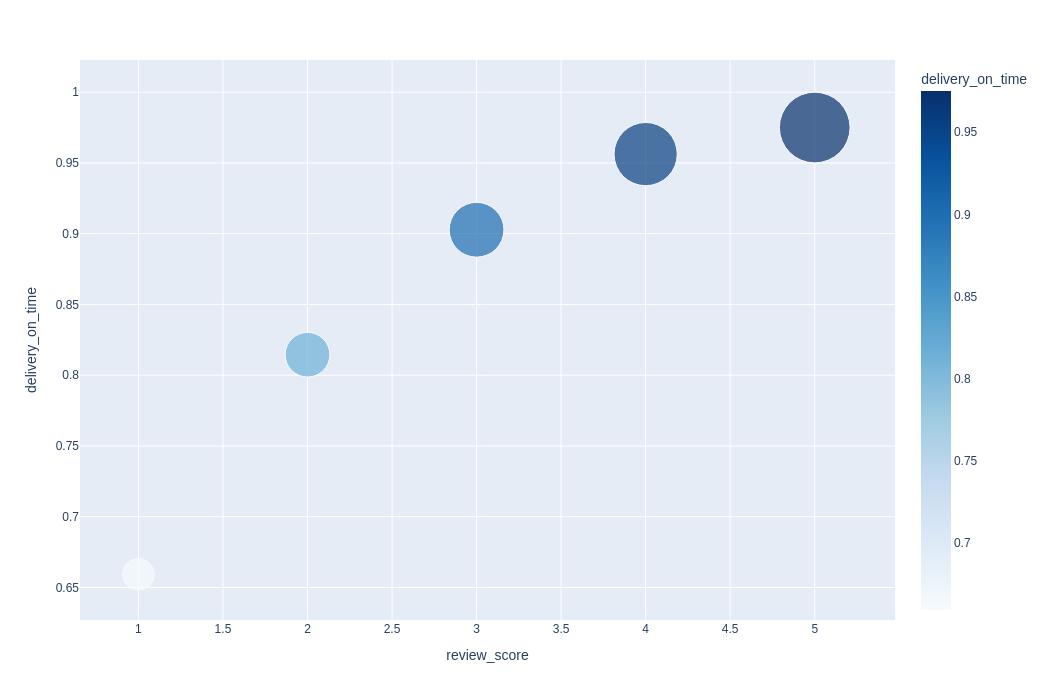

In [ ]:
df_aux = sales_per_state = df.groupby('review_score').delivery_on_time.mean().reset_index().sort_values(by='review_score', ascending = False)

fig = px.scatter (df_aux, x = 'review_score', y = 'delivery_on_time',
                 size = 'review_score', color = 'delivery_on_time',
                 hover_name = 'review_score', size_max = 50,
                 color_continuous_scale='Blues')

fig.update_layout(width=1050, height=700)

fig.show()

# GitHub display
png_bytes = fig.to_image(format="png", scale=1)
display(Image(data=png_bytes))

# 6. Feature Engineering

To improve model performance, we will generate **new features** inspired by the strong correlation between **delivery status and review scores.**


## 6.1 **Delivery time:** We will now create a set of delivery time-related features to capture the impact of logistics on customer satisfaction.

In [ ]:
# The order was delayed or not
df['delivery_delay_days'] = (df['real_delivery_time'] - df['estimated_delivery_time'])

df['is_late'] = (df['delivery_delay_days'] > 0).astype(int)

In [ ]:
# The order was delayed in shipping or not
df['shipping_delay_days'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']).dt.days

In [ ]:
df['was_delivered'] = df['order_status'].apply(lambda x: 1 if x == 'delivered' else 0)

In [ ]:
df[['order_delivered_customer_date','order_approved_at', 'estimated_delivery_time', 'real_delivery_time', 'delivery_delay_days', 'is_late', 'shipping_delay_days','review_score', 'delivery_on_time']].head()

,order_delivered_customer_date,order_approved_at,estimated_delivery_time,real_delivery_time,delivery_delay_days,is_late,shipping_delay_days,review_score,delivery_on_time
0,2017-05-25 10:35:35,2017-05-16 15:22:12,19,8.0,-11.0,0,6.0,4,1.0
1,2018-01-29 12:41:19,2018-01-12 20:58:32,24,16.0,-8.0,0,2.0,5,1.0
2,2018-06-14 17:58:51,2018-05-20 16:19:10,24,26.0,2.0,1,22.0,5,0.0
3,2018-03-28 16:04:25,2018-03-13 17:29:19,27,14.0,-13.0,0,14.0,5,1.0
4,2018-08-09 20:55:48,2018-07-29 10:10:09,16,11.0,-5.0,0,1.0,5,1.0


# 7. Modeling

## 7.1 Target variable

**First, we will create the response variable for the classification model that will be discussed.**

Since the business area has informed us that **the target is review scores 4 or 5, we will label this range as '1' and the ranges below as '0'.**

The goal of the project will be to determine whether a given customer **is likely to give a good or bad review.**

In [ ]:
# Copy of df for modeling process
df_model = df.copy()

In [ ]:
# Creation of the target variable

df_model['review_score'] = df_model['review_score'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
# Selecion
df_model = df_model[['customer_state',
                     'order_status',
                     'payment_type',
                     'payment_installments',
                     'payment_value',
                     'price',
                     'freight_value',
                     'product_category_name',
                     'product_description_lenght',
                     'product_photos_qty',
                     'product_weight_g',
                     'product_length_cm',
                     'product_height_cm',
                     'product_width_cm',
                     'order_purchase_timestamp',
                     'real_delivery_time',
                     'delivery_on_time',
                     'estimated_delivery_time',
                     'delivery_delay_days',
                     'is_late',
                     'was_delivered',
                     'shipping_delay_days',
                     'review_score']]

# 8. Machine Learning

## 8.1 Train test split

In [ ]:
from sklearn.model_selection import train_test_split

# Separating the features (independent variables) and the target (dependent variable)
x = df_model.drop('review_score', axis=1)  # Features
y = df_model['review_score']  # Target

# Train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

print(f'Train Data: {x_train.shape}, {y_train.shape}')
print(f'Test Data: {x_test.shape}, {y_test.shape}')

Train Data: (75957, 22), (75957,)
Test Data: (32553, 22), (32553,)


## 8.2 Features

In [ ]:
# Numerical features
numerical_features = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Caategorical features
categorical_features = x_train.select_dtypes(include=['object', 'category']).columns.tolist()


In [70]:
numerical_features

['payment_installments',
 'payment_value',
 'price',
 'freight_value',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'real_delivery_time',
 'delivery_on_time',
 'estimated_delivery_time',
 'delivery_delay_days',
 'is_late',
 'was_delivered',
 'shipping_delay_days']

In [ ]:
categorical_features

['customer_state', 'order_status', 'payment_type', 'product_category_name']

## 8.3 Random Forest Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder

# Categorical pipeline with TargetEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder(handle_unknown='value', handle_missing='value'))])

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Combine both
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numerical_features)
])

# Final pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestClassifier(random_state=10))
])


In [ ]:
# Training model
rf_pipeline.fit(x_train, y_train)

# Predict on training set
rf_train_predictions = rf_pipeline.predict(x_train)

# Predict on test set
rf_test_predictions = rf_pipeline.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report

print('Test Classification Report:')
print(classification_report(y_test, rf_test_predictions))


Test Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.37      0.51      8076
           1       0.82      0.97      0.89     24477

    accuracy                           0.82     32553
   macro avg       0.81      0.67      0.70     32553
weighted avg       0.82      0.82      0.80     32553



**Performance metrics**

**Accuracy**: measures the **proportion of correctly classified instances** out of the total number of instances in a classification problem. It provides an overall assessment of the model's correctness in predicting the classes of the samples.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Train Accuracy
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
print('Random Forest Train model accuracy:', rf_train_accuracy)

# Cross-validation accuracy
rf_cv_accuracy = cross_val_score(rf_pipeline, x_train, y_train, cv=3, scoring='accuracy')
print('Cross-validation accuracies:', rf_cv_accuracy)
print(f'Mean CV Accuracy: {rf_cv_accuracy.mean():.4f}')

# Test Accuracy
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
print('Random Forest Test model accuracy:', rf_test_accuracy)

Random Forest Train model accuracy: 0.9990389299208763
Cross-validation accuracies: [0.82479561 0.82293929 0.82049054]
Mean CV Accuracy: 0.8227
Random Forest Test model accuracy: 0.8213067920007373


**Confusion Matrix**

[[ 2980  5096]
 [  721 23756]]


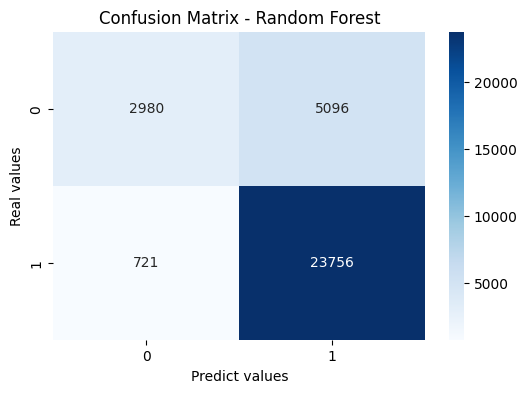

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculating the confusion matrix
rf_cm = confusion_matrix(y_test, rf_test_predictions)
print(rf_cm)


# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predict values')
plt.ylabel('Real values')
plt.show()

**Precision**: is the proportion of **true positive predictions out of the total instances predicted as positive**. It measures the accuracy of positive predictions and helps assess the model's ability to **avoid false positives**.

In [ ]:
#Precision
from sklearn.metrics import precision_score

# Train Precision score of classifier
rf_train_precision = precision_score(y_train, rf_train_predictions)

print('Precision Train Score of the Random Forest classifier is:', rf_train_precision)

# Cross-validated precision score
rf_cv_precision = cross_val_score(rf_pipeline, x_train, y_train, cv=3, scoring='precision')
print('Random Forest classifier cross-validated precision score:', rf_cv_precision)
print('Mean cross-validated precision score:', rf_cv_precision.mean())

# Test Precision score of classifier
rf_test_precision = precision_score(y_test, rf_test_predictions)

print('Precision Test Score of the Random Forest classifier is:', rf_test_precision)

Precision Train Score of the Random Forest classifier is: 0.9991161331692692
Random Forest classifier cross-validated precision score: [0.82673442 0.82476316 0.82402543]
Mean cross-validated precision score: 0.8251743387883904
Precision Test Score of the Random Forest classifier is: 0.8233744627755442


**Recall:** Recall, also known as sensitivity or true positive rate, is the proportion of **true positive predictions out of all actual positive instances**. It measures the model's ability to identify and capture all positive cases, **minimizing false negatives.**

In [ ]:
#Sensitivy (Recall)
from sklearn.metrics import recall_score

# Calculating the Train recall score of classifier
rf_train_recall = recall_score(y_train, rf_train_predictions)
print('Train Recall Score of the Random Forest classifier is:', rf_train_recall)

# Cross-validated recall score
rf_cv_recall = cross_val_score(rf_pipeline, x_train, y_train, cv=3, scoring='recall')
print('Random Forest classifier cross-validated precision score:', rf_cv_recall)
print('Mean cross-validated precision score:', rf_cv_recall.mean())

# Calculating the Test recall score of classifier
rf_test_recall = recall_score(y_test, rf_test_predictions)
print('Test Recall Score of the Random Forest classifier is:', rf_test_recall)

Train Recall Score of the Random Forest classifier is: 0.9996185323900679
Random Forest classifier cross-validated precision score: [0.97321057 0.97367873 0.97092176]
Mean cross-validated precision score: 0.9726036898321543
Test Recall Score of the Random Forest classifier is: 0.9705437757895167


**F1-score**: combines precision and recall into a single value, providing a **balanced measure** of a model's performance. It is the harmonic mean of precision and recall.

In [ ]:
from sklearn.metrics import f1_score

# Train F1 score of classifier
rf_train_f1_score = f1_score(y_train, rf_train_predictions)
print(f'Train F1 Score of the Random Forest classifier is:', rf_train_f1_score)

# Cross-validated f1 score
rf_cv_f1 = cross_val_score(rf_pipeline, x_train, y_train, cv=3, scoring='f1')
print('Random Forest classifier cross-validated precision score:', rf_cv_f1)
print('Mean cross-validated precision score:', rf_cv_f1.mean())

# Test F1 score of classifier
rf_test_f1_score = f1_score(y_test, rf_test_predictions)
print(f'Test F1 Score of the Random Forest classifier is:', rf_test_f1_score)

**ROC AUC Curve:** Measures the model’s ability to **distinguish between classes.** The ROC curve plots True Positive Rate vs. False Positive Rate at different thresholds, and the AUC (area under the curve) summarizes this performance into a single value between 0.5 (random) and 1.0 (perfect).

AUC for our classifier is: 0.7588306055094569


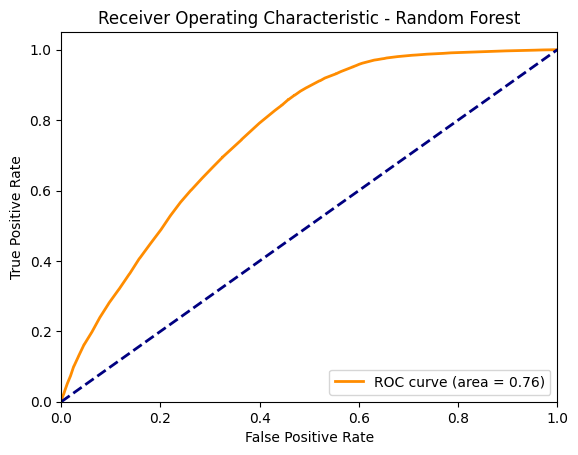

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Calculating and displaying the ROC curve for the Random Forest model
rf_probabilities = rf_pipeline.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_probabilities)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Printing AUC
print(f'AUC for our classifier is: {roc_auc_rf}')


plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc='lower right')
plt.show()

## 8.4 XGBoost Model

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier


# Pipeline for preprocessing categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder(handle_unknown='value', handle_missing='value'))])

# Pipeline for preprocessing of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

# ColumnTransformer for applying pipelines to corresponding columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)])

# Creating the XGBoost model
xgb_model = XGBClassifier(random_state=10)

# Apply preprocessing and apply XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)])

In [73]:
# Training model
xgb_pipeline.fit(x_train, y_train)

# Predict train
xgb_train_predictions = xgb_pipeline.predict(x_train)

# Predict test
xgb_test_predictions = xgb_pipeline.predict(x_test)

In [74]:
from sklearn.metrics import classification_report

print('Test Classification Report:')
print(classification_report(y_test, xgb_test_predictions))


Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.35      0.48      8076
           1       0.82      0.96      0.88     24477

    accuracy                           0.81     32553
   macro avg       0.79      0.65      0.68     32553
weighted avg       0.80      0.81      0.78     32553



**Performance Metrics - XGBoost**

**Accuracy**

In [75]:
# Train Accuracy
xgb_train_accuracy = accuracy_score(y_train, xgb_train_predictions)
print('XGBoost Train model accuracy:', xgb_train_accuracy)

# Cross-validation accuracy
xgb_cv_accuracy = cross_val_score(xgb_pipeline, x_train, y_train, cv=3, scoring='accuracy')
print('Cross-validation accuracies:', xgb_cv_accuracy)
print(f'Mean CV Accuracy: {xgb_cv_accuracy.mean():.4f}')

# Train Accuracy
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)
print('XGBoost Test model accuracy:', xgb_test_accuracy)

XGBoost Train model accuracy: 0.8430164435140935
Cross-validation accuracies: [0.81816027 0.81432916 0.81417118]
Mean CV Accuracy: 0.8156
XGBoost Test model accuracy: 0.8108008478481246


**Confusion Matrix:**

[[ 2788  5288]
 [  871 23606]]


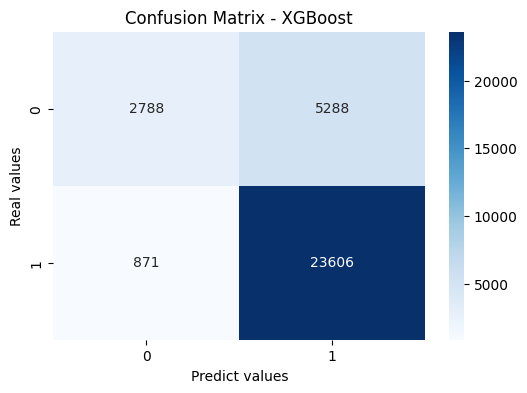

In [76]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculating the confusion matrix
rf_cm = confusion_matrix(y_test, xgb_test_predictions)
print(rf_cm)


# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predict values')
plt.ylabel('Real values')
plt.show()

**Precision:**

In [77]:
from sklearn.metrics import precision_score

# Train precision score of Xgboost
xgb_train_precision = precision_score(y_train, xgb_train_predictions)
print('Train Precision Score of the XGB classifier is:', xgb_train_precision)

# Cross-validated precision score
xgb_cv_precision = cross_val_score(xgb_pipeline, x_train, y_train, cv=3, scoring='precision')
print('XGB classifier cross-validated precision score:', xgb_cv_precision)
print('Mean cross-validated precision score:', xgb_cv_precision.mean())

# Test precision score of Xgboost
xgb_test_precision = precision_score(y_test, xgb_test_predictions)
print('Test Precision Score of the XGB classifier is:', xgb_test_precision)

Train Precision Score of the XGB classifier is: 0.8390549033558639
XGB classifier cross-validated precision score: [0.82491777 0.82129109 0.82171505]
Mean cross-validated precision score: 0.8226413030690903
Test Precision Score of the XGB classifier is: 0.8169862255139475


**Recall:**

In [78]:
from sklearn.metrics import recall_score

# Train Recall score of classifier
xgb_train_recall = recall_score(y_train, xgb_train_predictions)
print('Train Recall Score of the XGB classifier is:', xgb_train_recall )

# Cross-validated recall score
xgb_cv_recall = cross_val_score(xgb_pipeline, x_train, y_train, cv=3, scoring='recall')
print('XGB classifier cross-validated recall score:', xgb_cv_recall)
print('Mean cross-validated recall score:', xgb_cv_recall.mean())

# Calculating the recall score of classifier
xgb_test_recall = recall_score(y_test, xgb_test_predictions)
print('Test Recall Score of the XGB classifier is:', xgb_test_recall)

Train Recall Score of the XGB classifier is: 0.9815161603551117
XGB classifier cross-validated recall score: [0.96540782 0.96556388 0.96452351]
Mean cross-validated recall score: 0.9651650714384797
Test Recall Score of the XGB classifier is: 0.9644155738039792


**F1-Score:**

In [79]:
from sklearn.metrics import f1_score

# Calculating the Train F1 score of classifier
xgb_train_f1_score = f1_score(y_train, xgb_train_predictions)
print('Train F1 Score of the XGB classifier is:', xgb_train_f1_score)

# Cross-validated f1 score
xgb_cv_f1 = cross_val_score(xgb_pipeline, x_train, y_train, cv=3, scoring='f1')
print('XGB classifier cross-validated f1 score:', xgb_cv_f1)
print('Mean cross-validated f1 score:', xgb_cv_f1.mean())

# Calculating the Test F1 score of classifier
xgb_test_f1_score = f1_score(y_test, xgb_test_predictions)
print('Test F1 Score of the XGB classifier is:', xgb_test_f1_score)

Train F1 Score of the XGB classifier is: 0.9047116736990155
XGB classifier cross-validated f1 score: [0.88965054 0.88760311 0.88741056]
Mean cross-validated f1 score: 0.8882214049515295
Test F1 Score of the XGB classifier is: 0.8846002510726799


**Curva ROC-AUC:**

AUC for our classifier is: 0.746477295613638


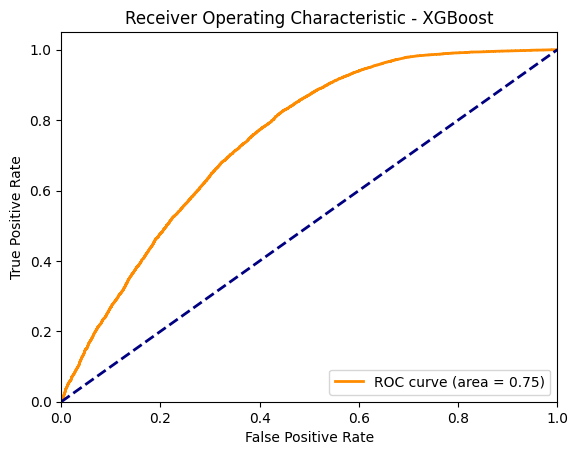

In [80]:
# Calculando e exibindo a curva ROC para o modelo XGBoost
xgb_probabilities = xgb_pipeline.predict_proba(x_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_probabilities)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Printing AUC
print(f'AUC for our classifier is: {roc_auc_xgb}')


plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc='lower right')
plt.show()


## 8.5 Comparing both classifiers

**Performance Metrics**

In [81]:
# Dataframe with metrics for Train and Test
data_models = {
    'Modelo': ['Random Forest', 'XGBoost'],

    # Accuracy
    'Train Accuracy': [rf_train_accuracy, xgb_train_accuracy],
    'Test Accuracy':  [rf_test_accuracy,  xgb_test_accuracy],

    # Precision
    'Train Precision': [rf_train_precision, xgb_train_precision],
    'Test Precision':  [rf_test_precision,  xgb_test_precision],

    # Recall
    'Train Recall': [rf_train_recall, xgb_train_recall],
    'Test Recall':  [rf_test_recall,  xgb_test_recall],

    # F1-score
    'Train F1-score': [rf_train_f1_score, xgb_train_f1_score],
    'Test F1-score':  [rf_test_f1_score,  xgb_test_f1_score],

    # ROC AUC (geralmente só em Teste é suficiente)
    'ROC AUC Test': [roc_auc_rf, roc_auc_xgb]
}

df_metrics = pd.DataFrame(data_models)

# Mostrar a tabela bonitinha
display(df_metrics)


,Modelo,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1-score,Test F1-score,ROC AUC Test
0,Random Forest,0.999039,0.821307,0.999116,0.823374,0.999619,0.970544,0.999367,0.890922,0.758831
1,XGBoost,0.843016,0.810801,0.839055,0.816986,0.981516,0.964416,0.904712,0.884600,0.746477


Both Random Forest and XGBoost achieved similar performance on the test set in terms of accuracy, precision, recall, F1-score, and ROC AUC.  
However, Random Forest shows almost perfect results on the training set (≈0.999 across metrics) but drops significantly on the test set, which is a **sign of overfitting.**

XGBoost, on the other hand, achieves slightly lower training scores but maintains very similar results on the test set. This **smaller gap between training and test metrics indicates better generalization and more consistent performance.**

In addition, XGBoost benefits from built-in regularization techniques and gradual fitting to control overfitting, efficient scalability, and the ability to handle large datasets. These characteristics make it a more reliable choice in practice, especially when aiming for robust performance and reduced overfitting risk.  

**Therefore, XGBoost was chosen as the final model.**


## 8.6 Feature Importance - Shap Values - XGBoost

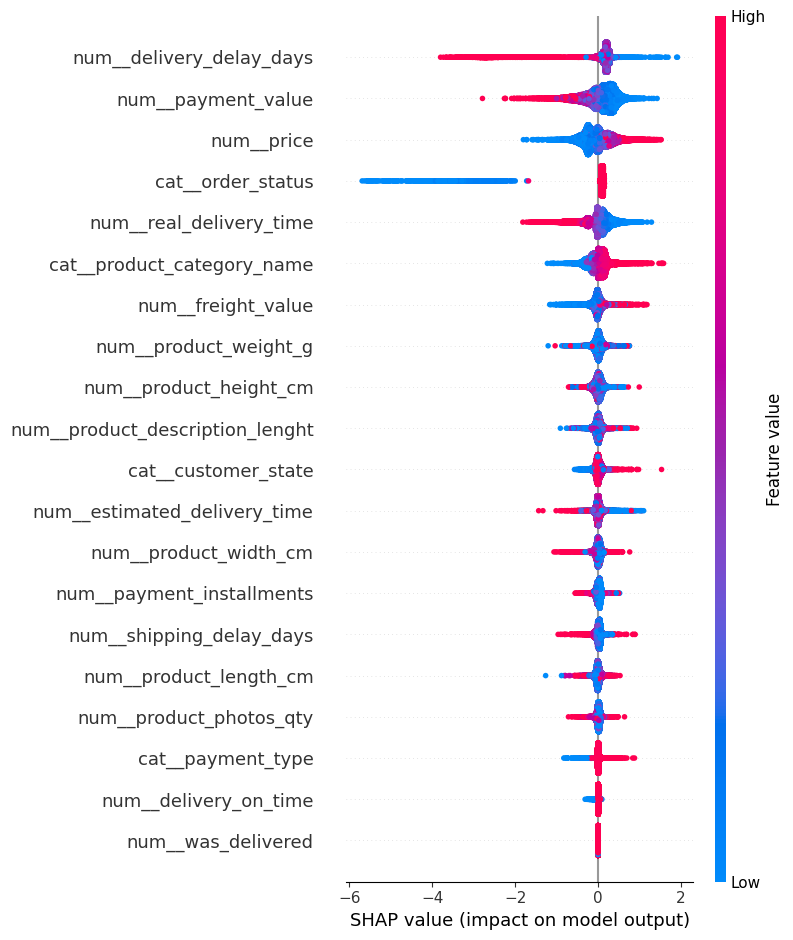

In [82]:
import shap

# Step 1: Rebuild feature names manually
transformed_feature_names = (
    [f'cat__{col}' for col in categorical_features] +
    [f'num__{col}' for col in numerical_features]
)

# Step 2: Transform test set with preprocessor
x_test_transformed = xgb_pipeline.named_steps['preprocessor'].transform(x_test)

# Step 3: Create SHAP explainer (assumes XGBClassifier)
explainer = shap.Explainer(xgb_pipeline.named_steps['model'])

# Step 4: Compute SHAP values
shap_values = explainer(x_test_transformed)

# Step 5: Plot SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, x_test_transformed, feature_names=transformed_feature_names)


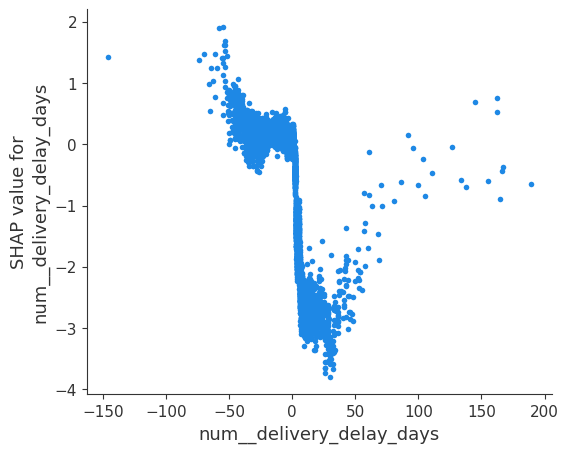

In [83]:
# Selecionar a feature para o gráfico de dependência
shap.dependence_plot('num__delivery_delay_days', shap_values.values, x_test_transformed, feature_names=transformed_feature_names,
                                                                                     interaction_index=None)

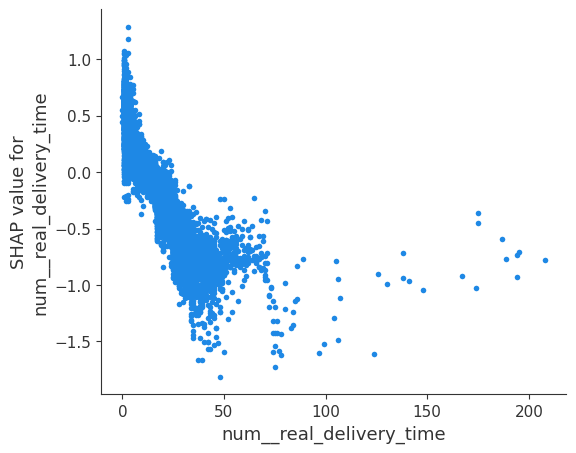

In [84]:
# Selecionar a feature para o gráfico de dependência
shap.dependence_plot('num__real_delivery_time', shap_values.values, x_test_transformed, feature_names=transformed_feature_names,
                                                                                     interaction_index=None)

**Model Explainability with SHAP**

SHAP (Shapley Additive explanations) helps us understand how each feature contributes to the model’s predictions. It assigns a value (positive or negative) to each feature, showing whether it increases or decreases the predicted review score.

In the summary plot, the **logistics features** stand out as the most impactful. Variables such as **delivery_delay_days, real_delivery_time, and delivery_on_time** dominate the model’s decision-making.

Longer delivery delays strongly reduce predicted review scores.

On-time deliveries push predictions upward, reflecting higher customer satisfaction.


💡 **Business Insight**
The analysis highlights that delivery performance is the main driver of customer satisfaction. To improve review scores on the Olist marketplace, the priority should be reducing delays, improving punctuality, and ensuring that promised delivery times are met.

## 8.7 Feature Selection with RFE

We applied **Recursive Feature Elimination (RFE)** to select the most relevant features for our XGBoost model.  
RFE works by **iteratively training the model, ranking features by importance, and removing the least useful ones** until the desired number of features is reached.  

Instead of optimizing for general accuracy, the evaluation during feature selection was guided by **precision**, since the business goal is to correctly identify customers likely to leave bad reviews and **avoid giving incentives to those who would rate positively.**

This ensures that the final subset of features not only simplifies the model but also maximizes performance on the metric most relevant to the use case.


In [85]:
from sklearn.feature_selection import RFE

# 1) Extract the final classifier from our pipeline
final_model = xgb_pipeline.named_steps['model']

# 2) Transform raw features using the pipeline preprocessor
x_train_transformed = xgb_pipeline.named_steps['preprocessor'].transform(x_train)
x_test_transformed  = xgb_pipeline.named_steps['preprocessor'].transform(x_test)

# 3) Get transformed feature names
feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 4) Fit RFE on the transformed training data with the same final model
rfe = RFE(final_model, n_features_to_select=10, step=1)
rfe.fit(x_train_transformed, y_train)

# 5) Build a ranking table (1 = selected by RFE, >1 = less important)
df_cols_ranking_rfe = pd.DataFrame({
    'feature': feature_names,
    'ranking': rfe.ranking_
}).sort_values('ranking')

# 6) Sweep different ranking thresholds and evaluate classification metrics
df_metrics_features_rfe = pd.DataFrame()

for n_features in sorted(range(1, int(df_cols_ranking_rfe['ranking'].max()) + 1), reverse=True):
    # Keep features whose RFE ranking <= threshold
    selected_features = df_cols_ranking_rfe.loc[df_cols_ranking_rfe['ranking'] <= n_features, 'feature'].tolist()
    num_selected = len(selected_features)

    # Subselect transformed matrices to the chosen columns
    x_train_sel = pd.DataFrame(x_train_transformed, columns=feature_names)[selected_features]
    x_test_sel  = pd.DataFrame(x_test_transformed,  columns=feature_names)[selected_features]

    # Refit the same classifier from scratch on the reduced feature set
    final_model.fit(x_train_sel, y_train)
    y_pred  = final_model.predict(x_test_sel)
    y_proba = final_model.predict_proba(x_test_sel)[:, 1]

    # Classification metrics (prioritizing precision)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall    = recall_score(y_test, y_pred, zero_division=0)
    f1        = f1_score(y_test, y_pred, zero_division=0)
    roc_auc   = roc_auc_score(y_test, y_proba)

    print(f'[Ranking ≤ {n_features}] Features: {num_selected} → '
          f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, ROC AUC: {roc_auc:.3f}')

    # Store results for later comparison
    df_metrics_features_rfe = pd.concat([
        df_metrics_features_rfe,
        pd.DataFrame({
            'ranking_threshold': [n_features],
            'n_features_used':  [num_selected],
            'precision':        [precision],
            'recall':           [recall],
            'f1':               [f1],
            'roc_auc':          [roc_auc],
        })
    ], ignore_index=True)

# 7) Sort by precision
df_metrics_features_rfe = df_metrics_features_rfe.sort_values('precision', ascending=False).reset_index(drop=True)

# 8) Retrieve the best configuration and list of features
best_row = df_metrics_features_rfe.iloc[0]
best_threshold   = int(best_row['ranking_threshold'])
best_n_features  = int(best_row['n_features_used'])

print(f'\n✅ Best setup: {best_n_features} features (ranking ≤ {best_threshold})')

best_features = df_cols_ranking_rfe.loc[df_cols_ranking_rfe['ranking'] <= best_threshold, 'feature'].tolist()
print('\n📋 Selected features in the best setup:')
print(best_features)


[Ranking ≤ 12] Features: 21 → Precision: 0.817, Recall: 0.964, F1: 0.885, ROC AUC: 0.746
[Ranking ≤ 11] Features: 20 → Precision: 0.817, Recall: 0.964, F1: 0.885, ROC AUC: 0.746
[Ranking ≤ 10] Features: 19 → Precision: 0.817, Recall: 0.964, F1: 0.885, ROC AUC: 0.746
[Ranking ≤ 9] Features: 18 → Precision: 0.816, Recall: 0.965, F1: 0.885, ROC AUC: 0.746
[Ranking ≤ 8] Features: 17 → Precision: 0.816, Recall: 0.964, F1: 0.884, ROC AUC: 0.746
[Ranking ≤ 7] Features: 16 → Precision: 0.817, Recall: 0.965, F1: 0.885, ROC AUC: 0.747
[Ranking ≤ 6] Features: 15 → Precision: 0.817, Recall: 0.964, F1: 0.885, ROC AUC: 0.745
[Ranking ≤ 5] Features: 14 → Precision: 0.817, Recall: 0.964, F1: 0.885, ROC AUC: 0.745
[Ranking ≤ 4] Features: 13 → Precision: 0.817, Recall: 0.965, F1: 0.885, ROC AUC: 0.748
[Ranking ≤ 3] Features: 12 → Precision: 0.817, Recall: 0.964, F1: 0.885, ROC AUC: 0.741
[Ranking ≤ 2] Features: 11 → Precision: 0.817, Recall: 0.964, F1: 0.885, ROC AUC: 0.743
[Ranking ≤ 1] Features: 10 → 

In [86]:
# Build mapping cat__i -> original categorical column (1-to-1 for TargetEncoder)
cat_mapping = {f'cat__{i+1}': col for i, col in enumerate(categorical_features)}

# Map transformed names back to original column names
mapped_best_features = [
    cat_mapping.get(f, f.replace('num__', ''))  # cat__i -> original cat; num__x -> x
    for f in best_features
]

# Final selected columns
selected_cat = [c for c in categorical_features if c in mapped_best_features]
selected_num = [c for c in numerical_features  if c in mapped_best_features]

print('Selected categorical columns:', selected_cat)
print('Selected numerical columns:', selected_num)

Selected categorical columns: ['customer_state', 'order_status', 'payment_type']
Selected numerical columns: ['payment_value', 'price', 'freight_value', 'product_description_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'real_delivery_time', 'delivery_delay_days', 'shipping_delay_days']


**New Pipeline with best features:**

In [87]:
# Pipeline for preprocessing categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder(handle_unknown='value', handle_missing='value'))])

# Pipeline for preprocessing of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

# ColumnTransformer for applying pipelines to corresponding columns
preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, selected_cat),
        ('num', numeric_transformer, selected_num)],
        remainder = "drop")

# Creating the XGBoost model
xgb_model_retrained = XGBClassifier(random_state=10)

xgb_pipeline_reduced = Pipeline(steps=[
    ('preprocessor', preprocessor_reduced),
    ('model', xgb_model_retrained),
])

In [88]:
# Training model
xgb_pipeline_reduced.fit(x_train, y_train)

# Predict train
xgb_reduced_train_predictions = xgb_pipeline_reduced.predict(x_train)

# Predict test
xgb_reduced_test_predictions = xgb_pipeline_reduced.predict(x_test)

In [89]:
from sklearn.metrics import classification_report

print('Test Classification Report:')
print(classification_report(y_test, xgb_reduced_test_predictions))

# Complement with Accuracy and ROC AUC
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f'Accuracy: {acc:.4f}')
print(f'ROC AUC:  {roc_auc:.4f}')

Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.34      0.47      8076
           1       0.82      0.97      0.89     24477

    accuracy                           0.81     32553
   macro avg       0.79      0.65      0.68     32553
weighted avg       0.80      0.81      0.78     32553

Accuracy: 0.8111
ROC AUC:  0.7404


## 8.8 Hyperparameter Tuning with Optuna:

**Optuna** is an automatic hyperparameter optimization framework that applies **Bayesian optimization with TPE (Tree-structured Parzen Estimator)** to efficiently search the hyperparameter space.  

Here we also optimize for **Precision**, since as explained before, the **business goal is to correctly identify customers likely to leave negative reviews.**

In [90]:
def objective(trial):
    '''
    Minimal Optuna objective:
    suggest a few core hyperparameters for the 'model' step (XGBoost) inside the pipeline
    and return mean CV Precision.
    '''
    params = {
        'model__n_estimators':     trial.suggest_int('model__n_estimators', 150, 500),
        'model__max_depth':        trial.suggest_int('model__max_depth', 3, 8),
        'model__learning_rate':    trial.suggest_float('model__learning_rate', 0.01, 0.2, log=True),
        'model__subsample':        trial.suggest_float('model__subsample', 0.7, 1.0),
        'model__colsample_bytree': trial.suggest_float('model__colsample_bytree', 0.7, 1.0),
    }

    clf = clone(xgb_pipeline_reduced).set_params(**params)

    cv = StratifiedKFold(n_splits=3,
                         shuffle=True,
                         random_state=10)

    scores = cross_val_score(clf,
                             x_train,
                             y_train,
                             cv=cv,
                             scoring='precision',
                             n_jobs=-1)
    return scores.mean()

# Run a small study (just to demonstrate the technique)
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=15, show_progress_bar=False)

print('Best parameters:', study.best_params)
print(f'Best mean CV Precision: {study.best_value:.4f}')


[I 2025-08-24 10:55:48,321] A new study created in memory with name: no-name-5d0634e3-c41e-459c-acd7-5fcba2616937
[I 2025-08-24 10:56:03,135] Trial 0 finished with value: 0.812620000720477 and parameters: {'model__n_estimators': 209, 'model__max_depth': 7, 'model__learning_rate': 0.012447268755444314, 'model__subsample': 0.9378283214118032, 'model__colsample_bytree': 0.9994614049936013}. Best is trial 0 with value: 0.812620000720477.
[I 2025-08-24 10:56:09,570] Trial 1 finished with value: 0.8161169242026215 and parameters: {'model__n_estimators': 217, 'model__max_depth': 4, 'model__learning_rate': 0.05191659324093417, 'model__subsample': 0.7841363880411368, 'model__colsample_bytree': 0.9402209992965371}. Best is trial 1 with value: 0.8161169242026215.
[I 2025-08-24 10:56:17,211] Trial 2 finished with value: 0.8145647525683288 and parameters: {'model__n_estimators': 255, 'model__max_depth': 6, 'model__learning_rate': 0.0187968748286419, 'model__subsample': 0.9160097769293184, 'model__c

Best parameters: {'model__n_estimators': 500, 'model__max_depth': 8, 'model__learning_rate': 0.18200889077364163, 'model__subsample': 0.711466852612684, 'model__colsample_bytree': 0.8427067918808204}
Best mean CV Precision: 0.8281


In [91]:
# Train final model with best params and evaluate on test
best_clf = clone(xgb_pipeline_reduced).set_params(**study.best_params)
best_clf.fit(x_train, y_train)

y_pred = best_clf.predict(x_test)
y_proba = best_clf.predict_proba(x_test)[:, 1]

# Print classification report (per class + macro/weighted avg)
print('\nClassification Report (Optuna-tuned XGB):')
print(classification_report(y_test, y_pred))

# Complement with Accuracy and ROC AUC
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f'Accuracy: {acc:.4f}')
print(f'ROC AUC:  {roc_auc:.4f}')


Classification Report (Optuna-tuned XGB):
              precision    recall  f1-score   support

           0       0.69      0.40      0.51      8076
           1       0.83      0.94      0.88     24477

    accuracy                           0.81     32553
   macro avg       0.76      0.67      0.69     32553
weighted avg       0.79      0.81      0.79     32553

Accuracy: 0.8074
ROC AUC:  0.7354


**Saving the model in a Pickle object and the selected features**

In [92]:
import pickle, json

# Salvar o modelo em um arquivo usando pickle
filename =  '/content/drive/MyDrive/Colab Notebooks/Olist_project/xgb_pipeline_final.pkl'
pickle.dump(xgb_pipeline_reduced, open(filename, 'wb'))
json.dump({"selected_cat": selected_cat, "selected_num": selected_num},
          open("selected_features.json","w"))


# 9. Model Deployment: MLflow + FastAPI


In this section, we´ll combine **MLflow** and **FastAPI** to serve a trained machine learning model in production.

- **MLflow** is used to track experiments, manage the model registry, and load the final model version marked as `@production`.
- **FastAPI** is used to create a REST API that receives prediction requests in JSON format, validates the input, and returns model predictions as a JSON response.
- The service is configured to run inside a Jupyter/Colab environment by using threading and `nest_asyncio`, allowing API testing directly from the notebook.

This setup simulates a lightweight **MLOps deployment pipeline where the model lifecycle (tracking → registry → serving) and the serving infrastructure are connected.**


## 9.1 MLflow

### 9.1.1 Experiment tracking

**Step 1:** Set Up MLflow Tracking with **SQLite & Ngrok**.
We configure MLflow to use a local SQLite database and expose the UI via ngrok for public access from Colab.

In [93]:
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

# Define the MLflow tracking URI with SQLite
MLFLOW_TRACKING_URI = 'sqlite:///mlflow.db'

# Start MLflow UI in background
subprocess.Popen(['mlflow', 'ui', '--backend-store-uri', MLFLOW_TRACKING_URI, '--port', '5000'])

# Set MLflow tracking URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Set or create experiment
mlflow.set_experiment('O_List_Project_reviewscore_prediction')

2025/08/24 11:00:12 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/24 11:00:12 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/content/mlruns/1', creation_time=1756033215027, experiment_id='1', last_update_time=1756033215027, lifecycle_stage='active', name='O_List_Project_reviewscore_prediction', tags={}>

**Step 2:** Authenticate and Start Ngrok Tunnel — enables external access to the MLflow tracking server running inside Google Colab.

In [94]:
print('Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/setup')
conf.get_default().auth_token = getpass.getpass()

# Expose MLflow UI via ngrok
port = 5000
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel {public_url} -> http://127.0.0.1:{port}")

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/setup
··········
 * ngrok tunnel https://8dc07eceb295.ngrok-free.app -> http://127.0.0.1:5000


**Step 3:** Log Trained Models to MLflow. Each run will appear in the MLflow UI under the chosen experiment. You can compare metrics and parameters between models.

In [95]:
run_id_rf = log_classification_model('Random Forest',
                                    'RandomForest_run1', #run name
                                     rf_pipeline,    #trained model
                                     x_train,
                                     y_train,
                                     x_test,
                                     y_test)

run_id_xgb = log_classification_model('XGBoost',
                                      'XGBoost_run1',
                                      xgb_pipeline_reduced,
                                      x_train,
                                      y_train,
                                      x_test,
                                      y_test)

[MLflow] Run ID: 87843fcf7fdc460990189105e6fa0dba
[MLflow] Run ID: 7a09420eaedd47c5b4208fe204f598c3


### 9.1.2 Model Registry

In [96]:
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri('sqlite:///mlflow.db')
client = MlflowClient()

run_id = run_id_xgb
model_name = 'review_score_classifier'

# Registry
result = mlflow.register_model(model_uri=f'runs:/{run_id}/model',
                              name=model_name)

model_version = result.version

2025/08/24 11:01:20 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/24 11:01:20 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Successfully registered model 'review_score_classifier'.
2025/08/24 11:01:20 WARNING mlflow.tracking._model_registry.fluent: Run with id 7a09420eaedd47c5b4208fe204f598c3 has no artifacts at artifact path 'model', registering model based on models:/m-5c9f8754d66f41f1a5aa2a205eed15f6 instead
Created version '1' of model 'review_score_classifier'.


In [97]:
# Promote to Production
client.transition_model_version_stage(name='review_score_classifier',
                                      version=model_version,
                                      stage='Production',
                                      archive_existing_versions=True)


client.set_registered_model_alias(name=model_name,
                                  alias='production',
                                  version=model_version)

print(f'Model {model_name} v{model_version} registered, promoted, and aliased @production')

Model review_score_classifier v1 registered, promoted, and aliased @production


**Getting the saved model in @production to make a prediction**

In [98]:
model = mlflow.pyfunc.load_model(f'models:/{model_name}@production')


sample = x_test.head(5).copy()

preds = model.predict(sample)

print('Sample shape:', sample.shape)
print('Predictions:', preds)

Sample shape: (5, 22)
Predictions: [1 1 1 1 1]


## 9.2. Fast API

**Serving the MLflow Model via API**

After training and registering our model in MLflow (and promoting it to the `@production` stage), the next step is to make it accessible for real-time predictions.  
We will achieve this by creating a REST API using **FastAPI**, which will:

- **Load the latest production model** directly from the MLflow Model Registry.  
- **Expose endpoints** for health checks and predictions.  
- **Accept JSON inputs** that match the model's expected schema.  
- **Return predictions** in real-time, enabling integration with external systems or applications.

By deploying our model as an API, we bridge the gap between model training and actual usage in production, allowing other services to send data and receive predictions without direct access to the training environment.


In [99]:
import threading
import nest_asyncio, uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List, Dict
import asyncio
import requests

nest_asyncio.apply()

# Step 1: Load model from MLflow registry
MODEL_NAME = 'review_score_classifier'
MODEL_STAGE = 'Production'
model = mlflow.pyfunc.load_model(f'models:/{MODEL_NAME}@production')

# Step 2: Define input data schema and create FastAPI app
class PredictPayload(BaseModel):
    records: List[Dict]

app = FastAPI(title='Review Score Prediction API (Notebook)', version='1.0')

@app.get('/')
def home():
    return {'status': 'ok', 'model': MODEL_NAME, 'alias': '@production'}

@app.post('/predict')
def predict(payload: PredictPayload):
    df = pd.DataFrame(payload.records)

    # Step 2.1: Map columns and enforce data types
    cast_map = {
        'payment_installments': 'float64',
        'payment_value': 'float64',
        'price': 'float64',
        'freight_value': 'float64',
        'product_description_lenght': 'float64',
        'product_photos_qty': 'float64',
        'product_weight_g': 'float64',
        'product_length_cm': 'float64',
        'product_height_cm': 'float64',
        'product_width_cm': 'float64',
        'real_delivery_time': 'float64',
        'delivery_on_time': 'float64',
        'estimated_delivery_time': 'int64',
        'delivery_delay_days': 'float64',
        'is_late': 'int64',
        'was_delivered': 'int64',
        'shipping_delay_days': 'float64'
    }

    cols_to_cast = {c: t for c, t in cast_map.items() if c in df.columns}
    df = df.astype(cols_to_cast)

    # Step 2.2: Convert datetime column if present
    if 'order_purchase_timestamp' in df.columns:
        df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

    preds = model.predict(df)
    return {'predictions': preds.tolist()}

# Step 3: Define Uvicorn server function
PORT = 8100

def start_server():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    config = uvicorn.Config(
        app,
        host="0.0.0.0",
        port=PORT,
        log_level="info",
        loop="asyncio",
        http="h11",
        lifespan="auto"
    )
    server = uvicorn.Server(config)
    server.run()

# Step 4: Run Uvicorn in background thread
thread = threading.Thread(target=start_server, daemon=True)
thread.start()


# Step 5: Wait for server to be ready (avoid 'connection refused')
assert wait_port('127.0.0.1', PORT), "Server didn't start on 8100"

# Step 6: Open public URL with ngrok tunnel
public_url = ngrok.connect(PORT).public_url
print('Public API URL:', public_url)

# Step 7: Health check endpoint
r = requests.get(f'{public_url}/')
print('Health:', r.status_code, r.text)

INFO:     Started server process [9250]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8100 (Press CTRL+C to quit)


Public API URL: https://cc5e3083fe68.ngrok-free.app
INFO:     34.106.4.1:0 - "GET / HTTP/1.1" 200 OK
Health: 200 {"status":"ok","model":"review_score_classifier","alias":"@production"}


**API Prediction Flow**

The FastAPI service acts as a bridge between incoming requests and the MLflow model stored in the Model Registry.  
The flow is as follows:

1. **Client sends data**:  
   A client application (e.g., another service, a frontend app, or a script) sends a JSON payload to the `/predict` endpoint.

2. **FastAPI processes request**:  
   - Validates the JSON structure.  
   - Converts the incoming data into a Pandas DataFrame.  
   - Ensures the data types match the model's input schema.

3. **MLflow model inference**:  
   - Loads the latest `@production` model from the MLflow Model Registry.  
   - Uses the model to generate predictions for the given input.

4. **Return response**:  
   - Sends the predictions back to the client as JSON.  
   - The client can then use these predictions in its workflow.

In [100]:
import requests

API_URL = public_url

payload = {
  'records': [
    {
      'customer_state': 'MS',
      'order_status': 'delivered',
      'payment_type': 'boleto',
      'payment_installments': 1.0,              # float
      'payment_value': 49.3,
      'price': 29.9,
      'freight_value': 19.4,
      'product_category_name': 'esporte_lazer',
      'product_description_lenght': 509.0,
      'product_photos_qty': 2.0,
      'product_weight_g': 650.0,
      'product_length_cm': 22.0,
      'product_height_cm': 12.0,
      'product_width_cm': 22.0,
      'order_purchase_timestamp': '2018-07-02T23:55:31',
      'real_delivery_time': 8.0,
      'delivery_on_time': 1.0,
      'estimated_delivery_time': 23,
      'delivery_delay_days': -15.0,
      'is_late': 0,
      'was_delivered': 1,
      'shipping_delay_days': 1.0
    }
  ]
}

r = requests.post(f'{API_URL}/predict', json=payload)
print(r.status_code, r.json())


INFO:     34.106.4.1:0 - "POST /predict HTTP/1.1" 200 OK
200 {'predictions': [1]}
